In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import random
import torch
from d2l import torch as d2l

In [ ]:
# #@save 这是 d2l（《动手学深度学习》）库的特殊注释，用于标记该函数，以便在 Jupyter Notebook 或 d2l 环境中保存代码，方便后续使用。对于 Python 本身，它没有影响，可以忽略。
# torch.normal(mean, std, size) 生成一个张量，包含了从给定均值 mean 和标准差 std 的离散正态分布中抽取的随机数。这里的均值和标准差分别为 0 和 1。
# size=(num_examples, len(w)): 形状为 (num_examples, len(w))，即每行是一个样本，每列是一个特征。
# torch.matmul() 矩阵乘法

def synthetic_data(w, b, num_examples): #@save 
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  # 加入随机噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0],'\nlabel:', labels[0])
print('features.shape:', features.shape)
print('labels.shape:', labels.shape)


features: tensor([0.4392, 1.2194]) 
label: tensor([0.9301])
features.shape: torch.Size([1000, 2])
labels.shape: torch.Size([1000, 1])


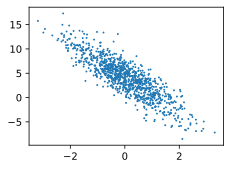

In [ ]:
# 通过生成第二个特征 features[:, 1] 和 labels 的散点图，可以更直观地观察两者间的线性关系。
# .detach() 断开计算图，防止梯度传播。detach() 方法来创建一个新的张量，该张量 脱离计算图
# d2l.plt 本质上是 matplotlib.pyplot，即 import matplotlib.pyplot as plt。

d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
d2l.plt.show()


In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # range 本身是一个不可变的对象，因此无法直接打乱顺序。将其转换为 list 后，变成了一个可变的对象，可以对其进行修改、打乱等操作。
    indices = list(range(num_examples))
    # 将 indices 列表中的索引进行 随机打乱，这样就可以确保每次读取数据时是随机的，避免数据顺序对训练过程的影响（打乱数据是防止模型过拟合的一种常见方法）。
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        # 每次 yield 返回一个数据批次，调用 data_iter 时函数会暂停执行，等到下次调用时继续从上次暂停的位置执行。
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break
    

tensor([[ 0.0885,  0.7321],
        [-1.1064,  0.4520],
        [ 0.3064,  0.8928],
        [ 0.5190,  0.4677],
        [ 0.4705, -0.3013],
        [-0.5656, -2.0747],
        [ 0.2693, -1.5660],
        [-0.4217,  0.1873],
        [ 1.8263, -2.0423],
        [ 1.0629, -2.1382]]) 
 tensor([[ 1.9027],
        [ 0.4718],
        [ 1.7732],
        [ 3.6491],
        [ 6.1659],
        [10.1417],
        [10.0637],
        [ 2.7154],
        [14.8143],
        [13.5772]])


In [10]:
# 初始化模型参数
# 通过 requires_grad=True 来指定需要求梯度，这样 PyTorch 在反向传播过程中才会计算这些参数的梯度。
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [11]:
# 定义模型
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [12]:
# 定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [13]:
# 定义优化算法
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    #torch.no_grad() 是一个上下文管理器，它可以在代码块内禁用自动梯度计算。
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            # 将每个参数的梯度归零。因为 PyTorch 会累积梯度，所以每次更新参数后，需要将梯度清零，避免梯度被多次累加。
            param.grad.zero_()

In [14]:
# 训练
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039504
epoch 2, loss 0.000141
epoch 3, loss 0.000046


In [15]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0002, -0.0010], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0010], grad_fn=<RsubBackward1>)
